In this notebook we construct a function to simulate images of lenses with convergence maps taken from Illustris and images from the PROBES dataset as sources. It's *nearly* as simple as possible: the one complexity is that the image is first simulated on a fine grid and then downsampled to the target one.

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from math import pi

from astropy.visualization import make_lupton_rgb
from matplotlib.colors import CenteredNorm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from caustic.constants import rad_to_arcsec
from caustic.cosmology import FlatLambdaCDMCosmology
from caustic.data import PROBESDataset, IllustrisKappaDataset
from caustic.lenses import KappaGrid
from caustic.sources import ImageSource
from caustic.utils import get_meshgrid


device = "cpu"
kappa_path = "../../data/hkappa356hst_TNG100_rau_spl_trainset_0.5kpc_z0/data_1.h5"
probes_path = "../../data/probes.h5"

Load data

In [10]:
ds_probes = PROBESDataset(probes_path)
ds_illustris = IllustrisKappaDataset(kappa_path)
n_pix = ds_illustris.n_pix

pix_Mpc = 0.5 * 1e-3
fov_Mpc = pix_Mpc * n_pix

Set cosmology and distance to lens

In [11]:
z_l = torch.tensor(1.5, device=device)
z_s = torch.tensor(2.3, device=device)
cosmology = FlatLambdaCDMCosmology()

fov = fov_Mpc / cosmology.angular_diameter_dist(z_l) * rad_to_arcsec
res = fov / n_pix
upsample_factor = 4
_thx_fine, _thy_fine = get_meshgrid(
    res / upsample_factor, upsample_factor * n_pix, upsample_factor * n_pix, device
)

# For plotting
extent = (-fov / 2, fov / 2, -fov / 2, fov / 2)

Create simulator. This indexes into the lens and source datasets, performs the ray-tracing and source interpolation, and downsamples.

In [12]:
lens = KappaGrid(fov, n_pix)
src = ImageSource()


def simulate(idx_lens, idx_src):
    kappa_map = ds_illustris[idx_lens]
    # Move channel first
    src_image = ds_probes[idx_src][None]

    # Raytrace
    bx, by = lens.raytrace(
        _thx_fine, _thy_fine, z_l, z_s, cosmology, kappa_map[None, None, :, :]
    )
    # Evaluate source
    mu_fine = src.brightness(bx, by, 0.0, 0.0, src_image, 1.0)
    # Downsample
    return F.avg_pool2d(mu_fine, upsample_factor)[0]

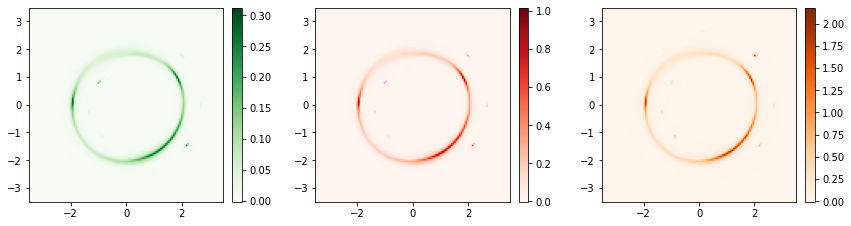

In [13]:
idx_lens = torch.randint(len(ds_illustris), size=())
idx_src = torch.randint(len(ds_probes), size=())

image = simulate(idx_lens, idx_src)

fig, axs = plt.subplots(1, 3, figsize=(12, 3.25))
for ax, channel, cmap in zip(axs, image, ["Greens", "Reds", "Oranges"]):
    im = ax.imshow(channel, extent=extent, origin="lower", cmap=cmap)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-3.5, 3.5)

fig.tight_layout()